In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import os

plt.rcParams["font.family"] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['CMU Sans Serif']
plt.rcParams['mathtext.default'] = 'regular'
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

SMALL_SIZE = 12
MEDIUM_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# 1. Parameter scans



In [2]:
scan_prefix = '../data/myframes_asc662_lactose/myframes_asc662_lactose_out/myframes_asc662_lactose'

In [3]:
def read_params_config(filename):
    df = pd.read_csv(filename, nrows=11)
    return df

def get_params_config(df, param):
    return df.loc[df['name'] == param]

def get_scan_file(search_dir):
    all_files = os.listdir(search_dir) 
    files = []
    for file in all_files:
        if "scan_" in file and ".csv" in file:
            files.append(os.path.join(search_dir ,file))
    return files

def get_scan_file_prefix(prefix):
    suffix_ordered =["_scan_mean_lambda.csv",
                    "_scan_gamma_lambda.csv",
                    "_scan_var_lambda.csv",
                    "_scan_mean_q.csv",
                    "_scan_gamma_q.csv",
                    "_scan_var_q.csv",
                    "_scan_beta.csv",
                    "_scan_var_x.csv",
                    "_scan_var_g.csv",
                    "_scan_var_dx.csv",
                    "_scan_var_dg.csv"]
    files = []
    for suffix in suffix_ordered:
        file = prefix + suffix
        if os.path.isfile(file):   
            files.append(file)
    return files


In [4]:
def read_1dscan(filename):
    tag = "scan_"
    base = filename.split("/")[-1]
    parameter = base[base.find(tag)+len(tag):-4]

    df = pd.read_csv(filename, skiprows=14)    
    return df[[parameter, 'likelihood']], parameter


def plot_1dscans(filenames, cols=3, width=14):
    rows = np.ceil(len(filenames)/cols).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(width,0.7*width/cols*rows))
    # fig = plt.figure()
    for i, ax in enumerate(axes.ravel()):
        if i<len(filenames):
            scan, parameter = read_1dscan(filenames[i])

            param_range = scan.to_numpy()[:,0]
            ll = scan.to_numpy()[:,1]

            ax.plot(param_range,ll, label='scan')

            params_config = read_params_config(filenames[i])
            init = get_params_config(params_config, parameter)["init"].values[0]
            init_idx = np.searchsorted(param_range, init)
            ax.axvline(x=init, label='init', ls='--', color='tab:orange')
            ax.axhline(y=ll[init_idx], ls='--', color='tab:orange')

            x_scan_max, y_scan_max = param_range[np.nanargmax(ll)], np.nanmax(ll)

            ax.axvline(x=x_scan_max, label='ll max', ls='--', color='tab:green')
            ax.axhline(y=y_scan_max, ls='--', color='tab:green')


            ax.set_xlabel(parameter)
            ax.set_ylabel('log likelihood')
            ax.ticklabel_format(style='sci', scilimits=(0,1), useOffset=False)
            ax.legend()

        else:
            plt.delaxes(ax)

    plt.tight_layout()
    plot_file = "/".join(filenames[0].split("/")[:-1]) + '/1dscans.pdf'
    plt.savefig(plot_file)
    plt.show()



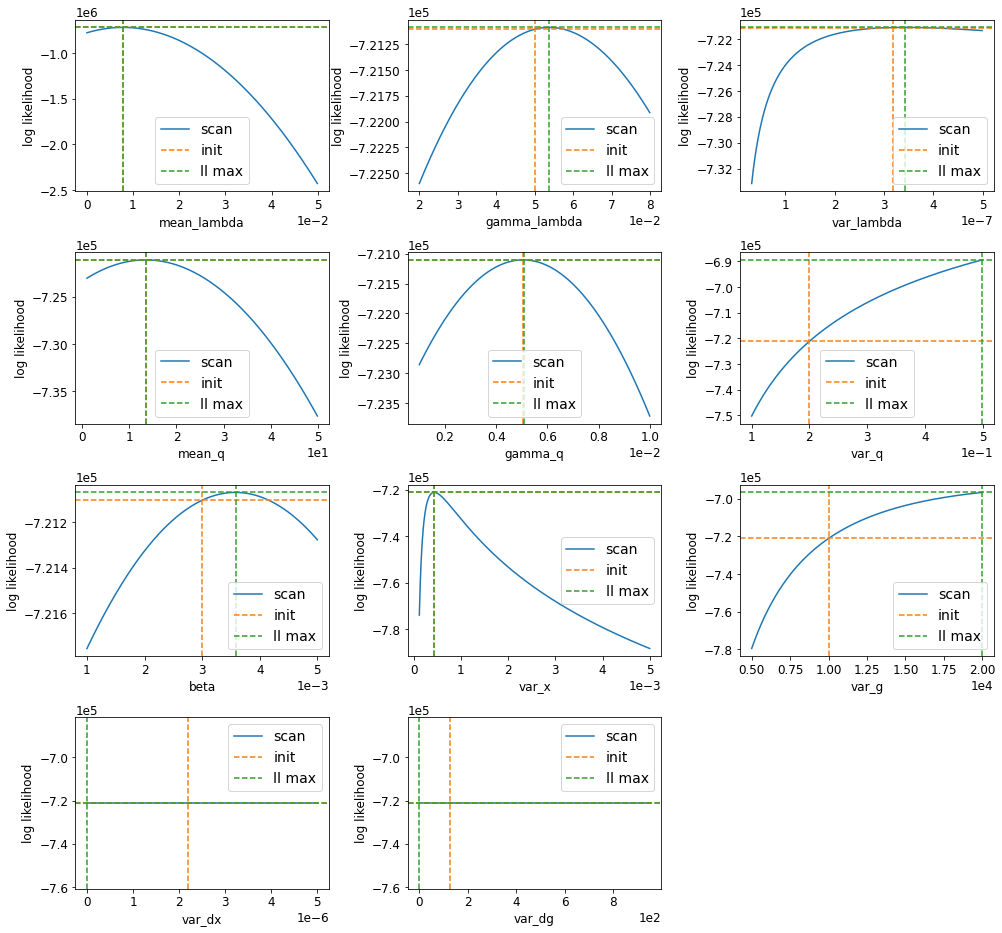

In [5]:
scan_files = get_scan_file_prefix(scan_prefix)
plot_1dscans(scan_files, cols=3)


# 2. Minimization

In [6]:
minimization_file = '../data/myframes_asc662_lactose/myframes_asc662_lactose_out/myframes_asc662_lactose_f_b012345678910.csv'

In [7]:

def read_iteration_process(filename):
    df = pd.read_csv(filename, skiprows=14)    
    return df[["iteration", 'likelihood']]

def plot_minimization(filename):
    mini_data = read_iteration_process(filename)
    fig, ax = plt.subplots(figsize=(5,3))
    iterations = mini_data.to_numpy()[:,0].astype(int)
    ll = mini_data.to_numpy()[:,1]
    ax.plot(iterations, ll)
    ax.scatter(iterations[-1], ll[-1], label="iteration: {:d}, log likelihood: {:.2f}".format(iterations[-1], ll[-1]))
    ax.legend()
    ax.set_xlabel("iterations")
    ax.set_ylabel("log likelihood")
    plt.show()



## Iterations 

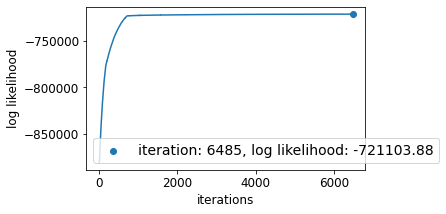

In [8]:
plot_minimization(minimization_file)


# 3. Time series and predictions

In [9]:
prediction_file = '../data/myframes_asc662_lactose/myframes_asc662_lactose_out/myframes_asc662_lactose_prediction.csv'
prediction_file_b = '../data/myframes_asc662_lactose/myframes_asc662_lactose_out/myframes_asc662_lactose_prediction_backward.csv'
prediction_file_f = '../data/myframes_asc662_lactose/myframes_asc662_lactose_out/myframes_asc662_lactose_prediction_forward.csv'

dat_file =  '../data/myframes_asc662_lactose/myframes_asc662_lactose.csv' 
data_prediction = pd.read_csv(prediction_file, skiprows=13)
data_backward = pd.read_csv(prediction_file_b, skiprows=13)
data_forward = pd.read_csv(prediction_file_f, skiprows=13)

data_dat = pd.read_csv(dat_file)

len(data_prediction), len(data_dat)

(104868, 104868)

In [10]:
def plot_time_series(data, cols, title=None, n0=0, n=200):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(10,7))
    ax2 = ax.twinx()
    if title !=None:
        plt.title(title)
    time = data['time_min'][n0:n]
    plots = []
    for i, col in enumerate(cols):
        if i%2==0:
            axes = ax
        else:
           axes = ax2
        d = data[col][n0:n]
        plots.append(axes.plot(time, d, 'o', c=cmap(i), label=col)[0])
        axes.plot(time, d, '-', c=cmap(i))
        axes.set_ylabel(col)

    ax.set_xlabel('time (min)')
    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()


def compare_time_series(data, cols, data2, cols2, data_slice, title=None):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(15,7))

    if title !=None:
        plt.title(title)

    time = data['time_min'][data_slice]
    plots = []

    for i, col in enumerate(cols):
        d = data[col][data_slice]
        plots.append(ax.plot(time, d, 'o', c=cmap(i), label=col)[0])

    for i, col in enumerate(cols2):
        d = data2[col][data_slice]
        plots.append(ax.plot(time, d, '-', c=cmap(i), label=col)[0])

    ax.set_xlabel('time (min)')
    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()


def compare_predictios(predictions, labels, col, data, data_col, data_slice, title=None, ratio=None):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(15,7))
    plots = []

    if title !=None:
        plt.title(title)
        ax.set_ylabel(title)

    time = data['time'][data_slice]

    for i, p in enumerate(predictions):
        if i == 0:
            ls = '-'
        else:
            ls ='--'
        plots.append(ax.plot(time, p[col][data_slice], ls, c=cmap(i), label=labels[i])[0])
    ax.set_xlabel("time")

    plots.append(ax.plot(time, data[data_col][data_slice], 'o', c=cmap(0), label="data")[0])

    if ratio!=None:
        ax2 = ax.twinx()
        plots.append(ax2.plot(time, 
                    predictions[ratio[0]][col][data_slice]/predictions[ratio[1]][col][data_slice],
                    color='grey', label='ratio')[0])
        ax2.axhline(y=1, ls='--', color='grey')
        ax2.set_ylabel("ratio")

    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()




## Data set *myframes_asc662_lactose*

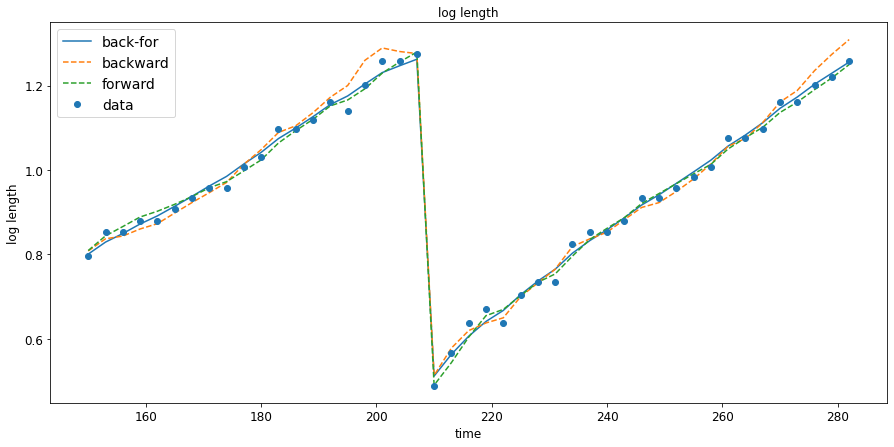

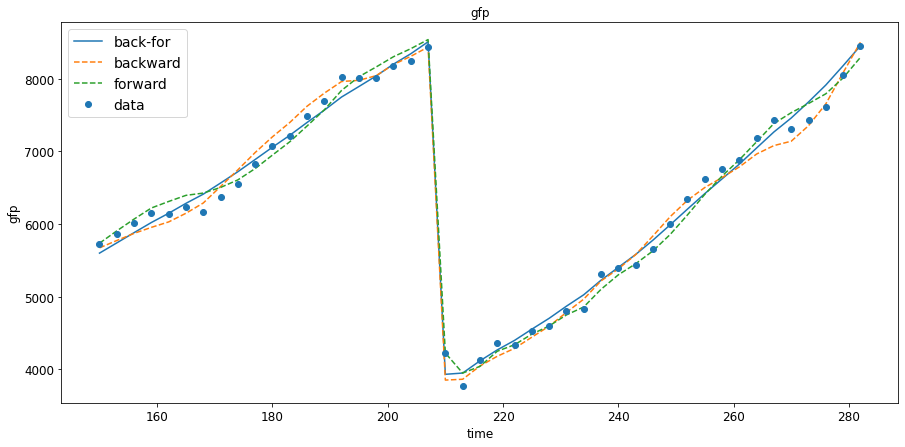

In [17]:
data_slice = slice(90, 135)

compare_predictios([data_prediction, data_backward,data_forward], ['back-for', 'backward', 'forward'], 'mean_x', data_prediction, 'log_length',data_slice, "log length")
compare_predictios([data_prediction, data_backward,data_forward], ['back-for', 'backward', 'forward'], 'mean_g', data_prediction, 'fp',data_slice, "gfp")
